<a href="https://colab.research.google.com/github/codeboy5/probml-notebooks/blob/add-densenet-jax/notebooks-d2l/densenet_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dense networks

We implement DenseNet.

Based on 7.7 of http://d2l.ai/chapter_convolutional-modern/densenet.html

In [ ]:
import jax
import jax.numpy as jnp  # JAX NumPy
from jax import lax
import matplotlib.pyplot as plt
import math
from IPython import display

from flax import linen as nn  # The Linen API
from flax.training import train_state  # Useful dataclass to keep train state

import numpy as np  # Ordinary NumPy
import optax  # Optimizers

import torchvision
import torch
from torch.utils import data
from torchvision import transforms
import tensorflow_datasets as tfds  # TFDS for MNIST

import random
import os
import time
from typing import Any, Callable, Sequence, Tuple
from functools import partial

rng = jax.random.PRNGKey(0)
!mkdir figures # for saving plots
ModuleDef = Any

mkdir: cannot create directory ‘figures’: File exists


# Dense blocks

A conv block uses BN-activation-conv in order.

In [ ]:
class ConvBlock(nn.Module):
    filters: int
    norm: ModuleDef

    @nn.compact
    def __call__(self, x):
        x = self.norm()(x)
        x = nn.relu(x)
        x = nn.Conv(self.filters, (3, 3), padding=[(1, 1), (1, 1)], dtype=jnp.float32)(x)
        return x

A DenseBlock is a sequence of conv-blocks, each consuming as input all previous outputs.

In [ ]:
class DenseBlock(nn.Module):
    filters: int
    num_convs: int
    norm: ModuleDef

    @nn.compact
    def __call__(self, x):

        for _ in range(self.num_convs):
            y = ConvBlock(self.filters, self.norm)(x)
            # Concatenate the input and output of each block on the channel dimension.
            x = jnp.concatenate(arrays=[x, y], axis=-1)

        return x

Example: we start with 3 channels, make a DenseBlock with 2 conv-blocks each with 10 channels, to get an output with 23 channels.

In [ ]:
train = False

norm = partial(nn.BatchNorm, use_running_average=not train, momentum=0.9, epsilon=1e-5, dtype=jnp.float32)

model = DenseBlock(10, 2, norm)
batch = jnp.ones((4, 8, 8, 3))  # (N, H, W, C) format
variables = model.init(jax.random.PRNGKey(0), batch)
output = model.apply(variables, batch)
output.shape

(4, 8, 8, 23)

# Transition layers

To prevent the number of channels exploding, we can add a transition layer, that uses 1x1 convolution. We can also reduce the spatial resolution using stride 2 average pooling.

In [ ]:
class TransitionBlock(nn.Module):
    filters: int
    norm: ModuleDef

    @nn.compact
    def __call__(self, x):
        x = self.norm()(x)
        x = nn.relu(x)
        x = nn.Conv(self.filters, (1, 1), padding=[(0, 0), (0, 0)], dtype=jnp.float32)(x)
        x = nn.avg_pool(x, (2, 2), (2, 2), padding=[(0, 0), (0, 0)])
        return x

Below we show an example where we map the 23 channels back down to 10, and halve the spatial dimensions.

In [ ]:
transition_model = TransitionBlock(10, norm)
batch = jnp.ones((4, 8, 8, 23))  # (N, H, W, C) format
variables = transition_model.init(jax.random.PRNGKey(0), batch)
output = transition_model.apply(variables, batch)
output.shape

(4, 4, 4, 10)

# Full model

In [ ]:
class DenseNet(nn.Module):
    @nn.compact
    def __call__(self, x, train: bool = True):

        norm = partial(nn.BatchNorm, use_running_average=not train, momentum=0.9, epsilon=1e-5, dtype=jnp.float32)

        # The first part of the model is similar to resnet.
        x = nn.Conv(64, (7, 7), (2, 2), [(3, 3), (3, 3)], dtype=jnp.float32)(x)
        x = nn.BatchNorm(use_running_average=not train, momentum=0.9, epsilon=1e-5, dtype=jnp.float32)(x)
        x = nn.relu(x)
        x = nn.max_pool(x, (3, 3), (2, 2), [(1, 1), (1, 1)])

        num_channels = 64
        growth_rate = 32
        num_convs_in_dense_blocks = [4, 4, 4, 4]

        for i, num_convs in enumerate(num_convs_in_dense_blocks):
            x = DenseBlock(growth_rate, num_convs, norm)(x)
            # This is the number of output channels in the previous dense block
            num_channels += num_convs * growth_rate
            # A transition layer that halves the number of channels is added between the dense blocks.
            if i != len(num_convs_in_dense_blocks) - 1:
                x = TransitionBlock(num_channels // 2, norm)(x)
                num_channels = num_channels // 2

        x = norm()(x)
        x = nn.relu(x)
        x = jnp.mean(x, axis=(1, 2))  # Works as adaptive avg pooling
        x = nn.Dense(10, dtype=jnp.float32)(x)
        x = jnp.asarray(x, np.float32)

        return x

In [ ]:
model = DenseNet()
batch = jnp.ones((1, 224, 224, 1))  # (N, H, W, C) format
variables = model.init(jax.random.PRNGKey(0), batch)
output = model.apply(variables, batch, False)
output.shape

(1, 10)

In [ ]:
model = DenseNet()
batch = jnp.ones((1, 96, 96, 1))  # (N, H, W, C) format
variables = model.init(jax.random.PRNGKey(0), batch)
output = model.apply(variables, batch, False)
output.shape

(1, 10)

# Training

We fit the model to Fashion-MNIST. We rescale images from 28x28 to 96x96, so that the input to the final average pooling layer has size 3x3. We notice that the training speed is much less than for ResNet.

In [ ]:
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root="../data", train=False, transform=trans, download=True)
    return (
        data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=2),
        data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=2),
    )

# Create train state

In [ ]:
class TrainState(train_state.TrainState):
    batch_stats: Any

In [ ]:
def create_train_state(rng, learning_rate, momentum):
    cnn = DenseNet()
    variables = cnn.init(rng, jnp.ones([1, 96, 96, 1], jnp.float32))
    params, batch_stats = variables["params"], variables["batch_stats"]
    tx = optax.sgd(learning_rate, momentum)
    state = TrainState.create(apply_fn=cnn.apply, params=params, tx=tx, batch_stats=batch_stats)
    return state

# Metric computation

In [ ]:
def compute_metrics(*, logits, labels):
    one_hot = jax.nn.one_hot(labels, num_classes=10)
    loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=one_hot))
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    numcorrect = jnp.sum(jnp.argmax(logits, -1) == labels, dtype=jnp.float32)
    metrics = {"loss": loss, "accuracy": accuracy, "numcorrect": numcorrect}
    return metrics

# Training step

In [ ]:
@jax.jit
def train_step(state, batch):
    """Train for a single step."""

    def loss_fn(params):
        logits, new_model_state = state.apply_fn(
            {"params": params, "batch_stats": state.batch_stats}, batch["image"], mutable=["batch_stats"]
        )
        one_hot = jax.nn.one_hot(batch["label"], num_classes=10)
        loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=one_hot))

        return loss, (new_model_state, logits)

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    aux, grads = grad_fn(state.params)
    # grads = lax.pmean(grads, axis_name='batch')

    new_model_state, logits = aux[1]
    metrics = compute_metrics(logits=logits, labels=batch["label"])

    new_state = state.apply_gradients(grads=grads, batch_stats=new_model_state["batch_stats"])

    return new_state, metrics

In [ ]:
def eval_step(state, batch):
    variables = {"params": state.params, "batch_stats": state.batch_stats}
    logits = state.apply_fn(variables, batch["image"], train=False, mutable=False)
    return compute_metrics(logits=logits, labels=batch["label"])

In [ ]:
def eval_model(state, test_iter):
    batch_metrics = []

    for i, (X, y) in enumerate(test_iter):
        batch = {}
        batch["image"] = jnp.reshape(jnp.float32(X), (-1, 96, 96, 1))
        batch["label"] = jnp.float32(y)
        metrics = eval_step(state, batch)
        batch_metrics.append(metrics)

    # compute mean of metrics across each batch in epoch.
    batch_metrics_np = jax.device_get(batch_metrics)
    epoch_metrics_np = {k: np.mean([metrics[k] for metrics in batch_metrics_np]) for k in batch_metrics_np[0]}

    return epoch_metrics_np["accuracy"]

# Animator and Timer

In [ ]:
class Animator:
    """For plotting data in animation."""

    def __init__(
        self,
        xlabel=None,
        ylabel=None,
        legend=None,
        xlim=None,
        ylim=None,
        xscale="linear",
        yscale="linear",
        fmts=("-", "m--", "g-.", "r:"),
        nrows=1,
        ncols=1,
        figsize=(3.5, 2.5),
    ):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        display.set_matplotlib_formats("svg")
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [
                self.axes,
            ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


class Timer:
    """Record multiple running times."""

    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()


class Accumulator:
    """For accumulating sums over `n` variables."""

    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

# Training and Evaluating the Model

In [ ]:
train_iter, test_iter = load_data_fashion_mnist(512, resize=96)

In [ ]:
rng, init_rng = jax.random.split(rng)

In [ ]:
learning_rate = 0.1
momentum = 0.9

In [ ]:
state = create_train_state(init_rng, learning_rate, momentum)
del init_rng  # Must not be used anymore.

In [ ]:
num_epochs = 10

880.9 examples/sec on cuda:0
loss 0.132, train acc 0.951, test acc 0.922


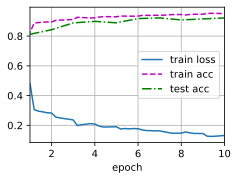

In [ ]:
timer = Timer()
animator = Animator(xlabel="epoch", xlim=[1, num_epochs], legend=["train loss", "train acc", "test acc"])
num_batches = len(train_iter)
device = torch.device(f"cuda:{0}")

for epoch in range(num_epochs):
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for i, (X, y) in enumerate(train_iter):
        timer.start()
        batch = {}
        batch["image"] = jnp.reshape(jnp.float32(X), (-1, 96, 96, 1))
        batch["label"] = jnp.float32(y)
        state, metrics = train_step(state, batch)
        metric.add(metrics["loss"] * X.shape[0], metrics["numcorrect"], X.shape[0])
        timer.stop()
        train_l = metric[0] / metric[2]
        train_acc = metric[1] / metric[2]
        if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
            animator.add(epoch + (i + 1) / num_batches, (train_l, train_acc, None))

    test_acc = eval_model(state, test_iter)
    animator.add(epoch + 1, (None, None, test_acc))


print(f"{metric[2] * num_epochs / timer.sum():.1f} examples/sec " f"on {str(device)}")
print(f"loss {train_l:.3f}, train acc {train_acc:.3f}, " f"test acc {test_acc:.3f}")